In [1]:
#Setup
import numpy as np
from pylab import *
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import configparser
import codecs
import json
import csv


mpl.rcParams['agg.path.chunksize'] = 100000

In [2]:
#Setup (Visual)
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style('whitegrid')

plt.rcParams["figure.figsize"] = (25,20)
plt.rcParams['figure.facecolor'] = 'white'

#colormap settings
#define legend colormap
cmap = plt.cm.plasma
cmap2 = plt.cm.cool
def colormap(input):
    custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
        Line2D([0], [0], color=cmap(.2), lw=4),
        Line2D([0], [0], color=cmap(.4), lw=4),
        Line2D([0], [0], color=cmap(.6), lw=4),
        Line2D([0], [0], color=cmap(.8), lw=4),
        Line2D([0], [0], color=cmap(1.), lw=4)]
    custom_lines2 = [Line2D([0], [0], color=cmap2(0.), lw=4),
        Line2D([0], [0], color=cmap2(.2), lw=4),
        Line2D([0], [0], color=cmap2(.4), lw=4),
        Line2D([0], [0], color=cmap2(.6), lw=4),
        Line2D([0], [0], color=cmap2(.8), lw=4),
        Line2D([0], [0], color=cmap2(1.), lw=4)]
    if input ==1:
        return custom_lines
    if input ==2:
        return custom_lines2
    else:
        return custom_lines

### SETTINGS

In [11]:
#csv data for operation line
def csv_df(data):
    return pd.read_csv('./Data/' + data  +'.csv', skiprows=1, names=["WC","PRC"])

#text data (Option)
def test_data(data):   
    return pd.read_table('./Data/' + data+'.txt', skiprows=1, header=0,index_col=False)

#map data in .txt form
def map_array(cmap):   
    return pd.read_table('./Data/' + cmap +'.txt', skiprows=9, header=0, names=["NC","WC","PRC","ETAC"])


def all_datas_plot(cmap,data1,data2,color1,color2,xlim,ylmin,ylmax):
    df=cmap
    datax1=data1['WC']
    datay1=data1['PRC']
    datax2=data2['WC']
    datay2=data2['PRC']
    df['spdline']=df.groupby('NC').ngroup()
    rpmgrp=df.groupby('spdline')
    nmax=rpmgrp.ngroups
    surgelinex=list()
    surgeliney=list()
    chokelinex=list()
    chokeliney=list()
      
    #plot setting
    plt.figure(0)
    plt.title("Compressor Map_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('PRC [-]')
    plt.axis ([0,xlim,ylmin,ylmax])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(ylmin, ylmax, (ylmax-ylmin)/20))
    
    plt.figure(1)
    plt.title("Flow-EtaC_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('EtaC [-]')
    plt.axis ([0,xlim,0.5,0.8])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(0.5, 0.8, 0.3/20))
    
    plt.figure(2)
    plt.title("Flow-PRC_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('PRC [-]')
    plt.axis ([0,xlim,ylmin,ylmax])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(ylmin, ylmax, (ylmax-ylmin)/20))  

    #obtain efficiency contour
    """
    k=0       
    etatmap.clear()
    flowtmap.clear()
    while k < len(rpmmap):
        flowlist=rpmmap[k][flowname].to_list()
        prtlist=rpmmap[k][ername].to_list()
        etalist=rpmmap[k][etaname].to_list()
        etatj = np.interp(PRT,prtlist,etalist)
        flowtj = np.interp(PRT,prtlist,flowlist)
        etatmap.append(etatj)
        flowtmap.append(flowtj)
        #scatter(flowtmap,etatmap,color=cmap2(vaneopening))
        plot(flowtmap,etatmap,color=cmap2(vaneopening))
        k+=1
    """ 
        
    #plot efficiency contour
    plt.figure(0)
    x=df['WC']
    y=df['PRC']
    z=df['ETAC']
    n=11
    xi, yi = np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n)
    zi =  gaussian_filter1d(z, sigma=2)
    Y,X=np.meshgrid(yi,xi)
    Z1 = interpolate.griddata((y,x),z,(Y,X),method='cubic')
    Z2 = interpolate.griddata((y,x),zi,(Y,X),method='cubic')  #with gaussian filter
    plt.contourf(X,Y,Z1, 14 ,cmap='bwr',alpha=0.3)
    plt.colorbar()
    plt.contour(X,Y,Z1, 7 ,colors='slategrey')
  

    #Plot speedlines
    i=0
    while i<nmax:
        rpmi=rpmgrp.get_group(i)
        wci=rpmi['WC']
        prci=rpmi['PRC']
        chokelinex.append(wci.max())
        chokeliney.append(prci.min())
        surgelinex.append(wci.min())
        surgeliney.append(prci.max())
        revi=str(int(rpmi['NC'].iloc[0]))
        plt.figure(0)
        plt.plot(wci, prci,"midnightblue", label=revi + ' rpm', linewidth=1)   
        
        #plt EtaC
        plt.figure(1)
        plt.plot(wci,rpmi['ETAC'],"red", label=revi+'rpm(Flow-EtaC)')
                
        #plt PRC
        plt.figure(2)
        plt.plot(wci,prci,"blue", label=revi+'rpm(Flow-PRC)')
                
        i+=1   
        
    #Surge line and choke line
    plt.figure(0)
    plt.plot(surgelinex, surgeliney,"midnightblue", label = 'GS Surgeline', linewidth=4)
    plt.plot(chokelinex, chokeliney,"midnightblue", label = 'GS Chokeline', linewidth=4)   
    
    #plot datas
    plt.plot(datax1, datay1,color1, label = name1, linewidth=1)
    plt.plot(datax2, datay2,color2, label = name2, linewidth=1)
    plt.legend()
    plt.savefig('./Data/CMaP' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    
    plt.figure(1)
    plt.legend
    plt.savefig('./Data/EtaC' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    
    plt.figure(2)
    plt.legend
    plt.savefig('./Data/PRC' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)


### Plot Data

C:\Users\131103\AppData\Local\Temp/ipykernel_4184/585870559.py:83: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


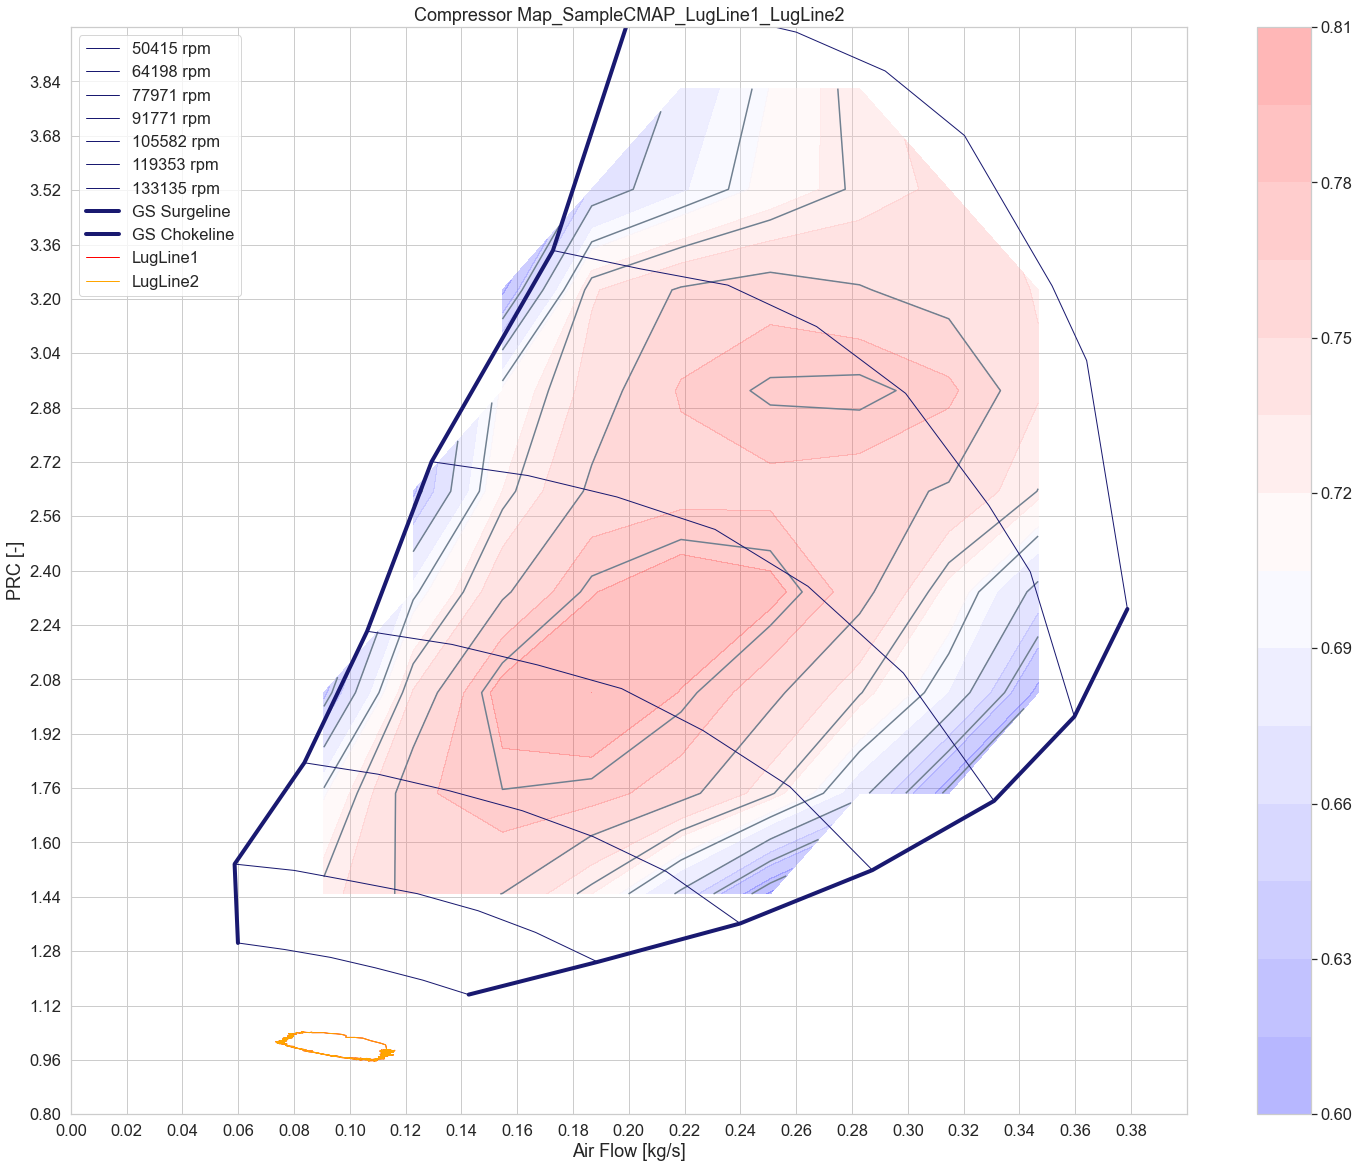

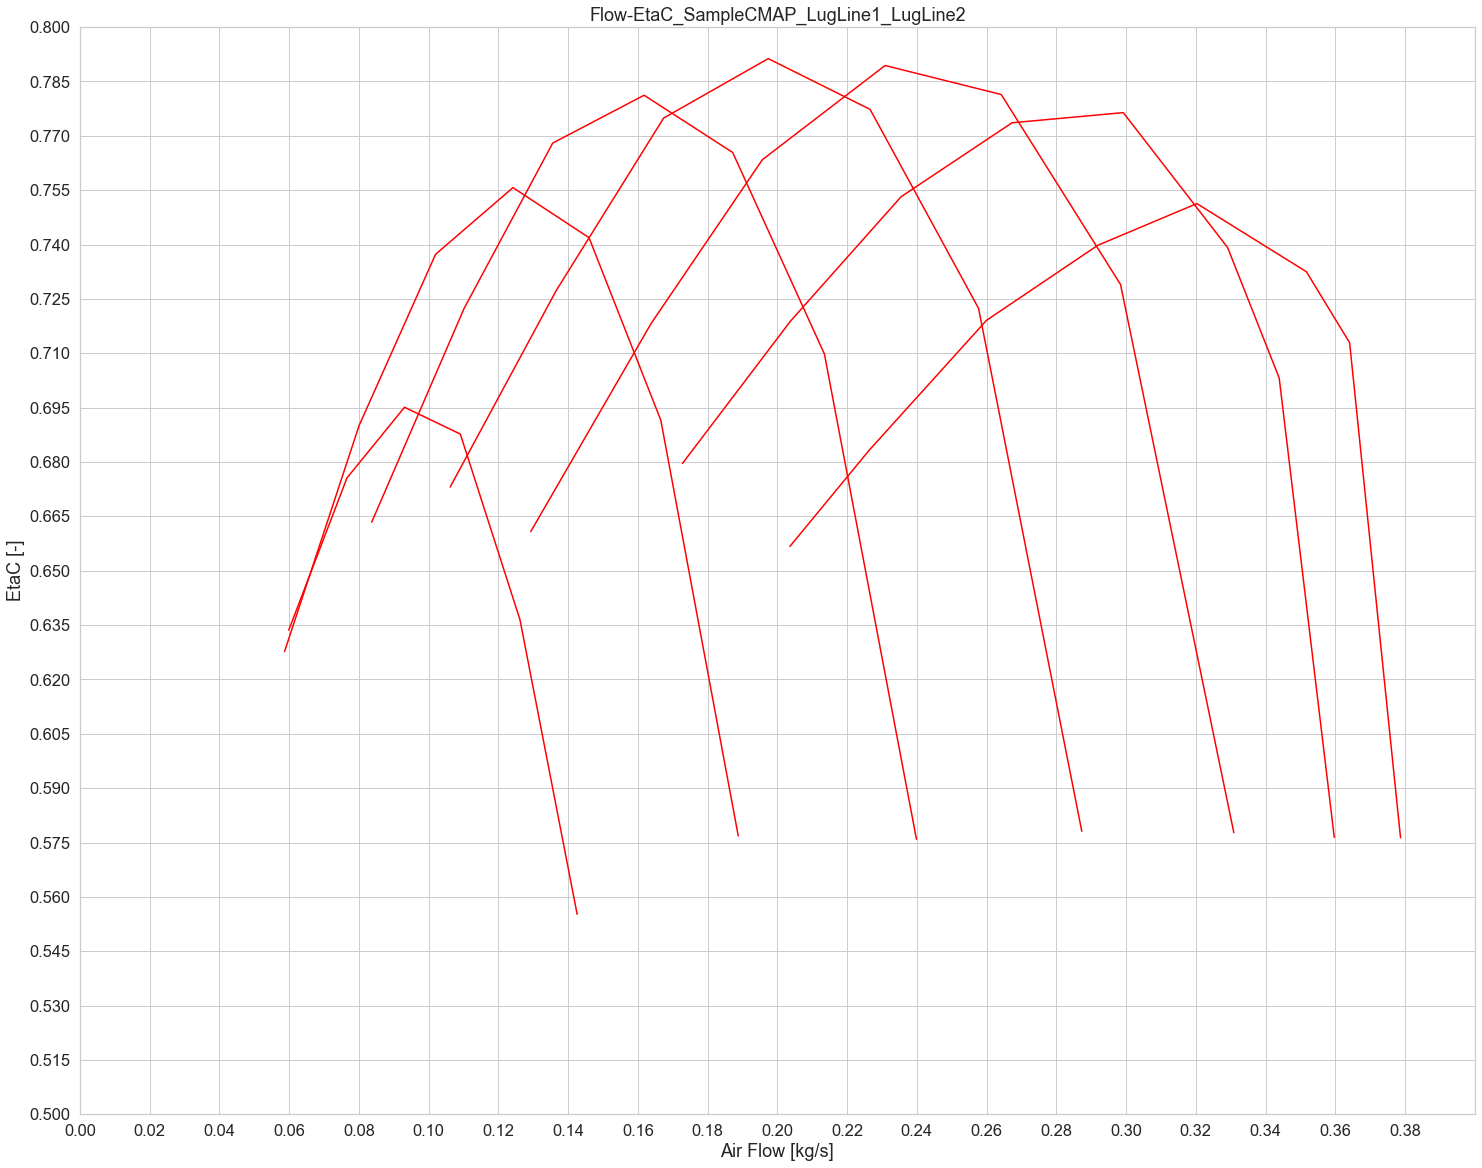

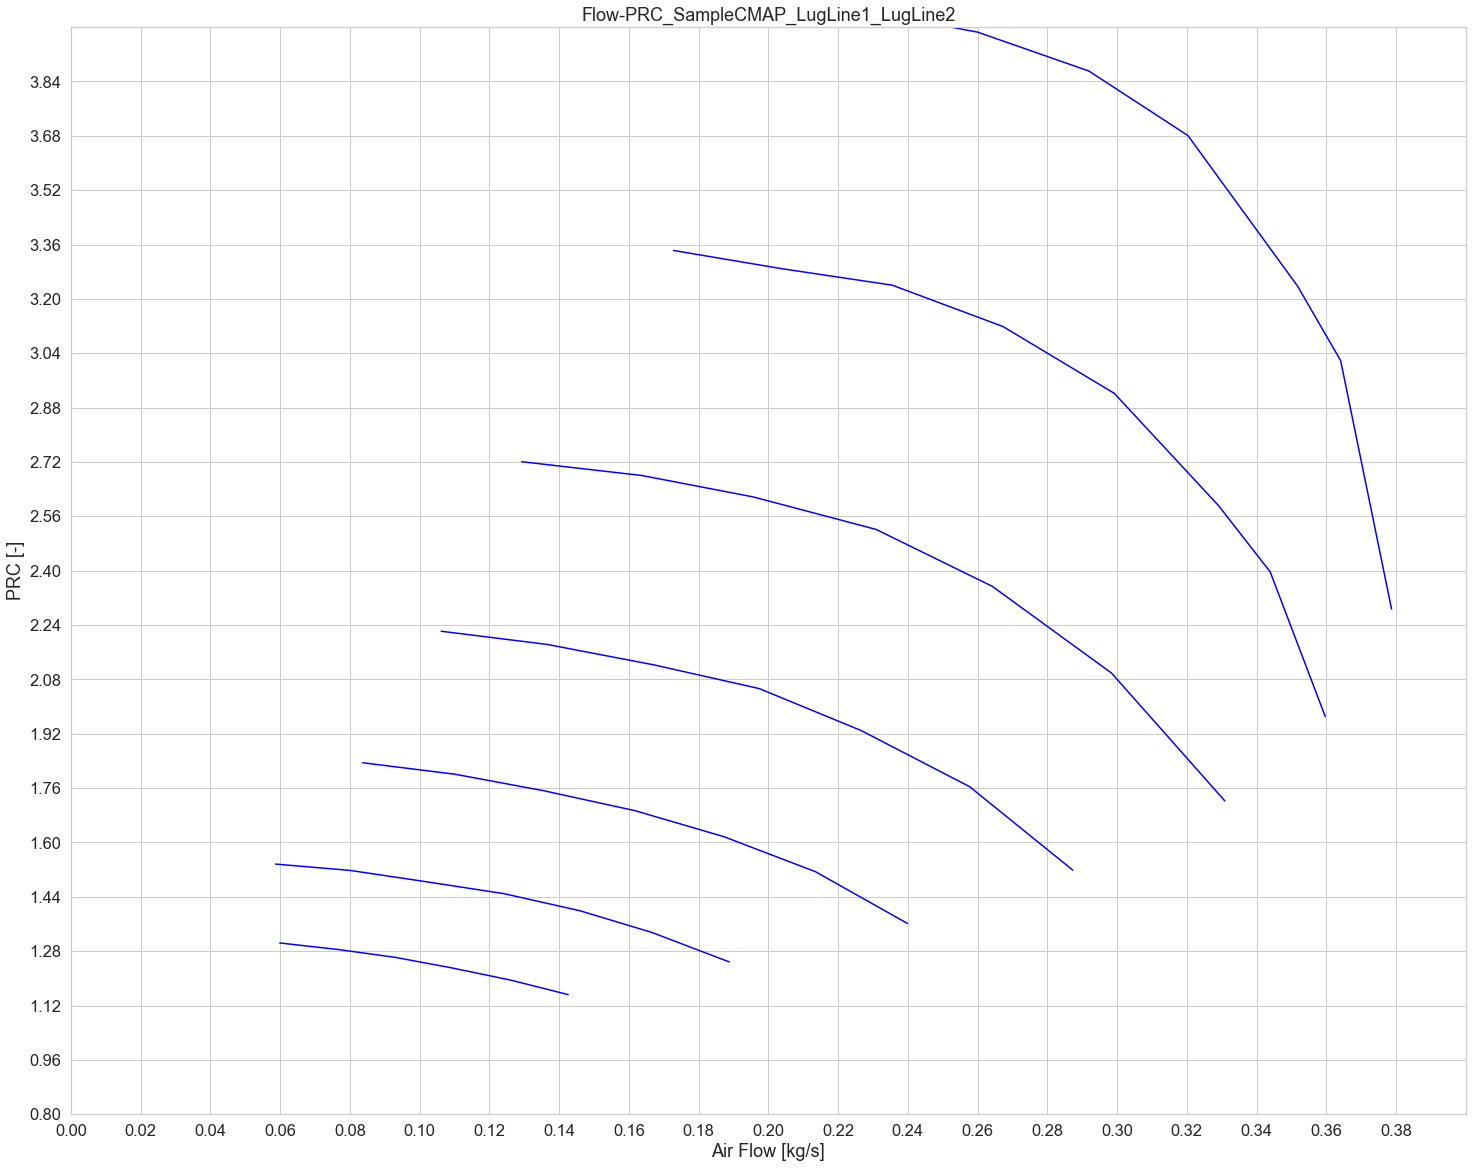

In [12]:
#specify data names
cmapname = "SampleCMAP"
name1 = "LugLine1" #.csv file for 1st data set
name2 = "LugLine2" #.csv file for 2nd data set
color1 = "red" #plotting color for 1st data set
color2 = "orange" #plotting color for 2nd data set

all_datas_plot(map_array(cmapname),csv_df(name1),csv_df(name2),color1, color2, 0.4,0.8,4.0) #Syntax: map name, 1st dataset, 2nd dataset, color1, color2, xrange(air flow), yrange(PRCmin, PRCmax)


